In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import ngrams


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# load data
raw_data = pd.read_csv('DisneylandReviews.csv', encoding='latin')
raw_data.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [4]:
raw_data.Branch.value_counts()

Disneyland_California    19406
Disneyland_Paris         13630
Disneyland_HongKong       9620
Name: Branch, dtype: int64

In [5]:
raw_data.Reviewer_Location.value_counts()

United States     14551
United Kingdom     9751
Australia          4679
Canada             2235
India              1511
                  ...  
Namibia               1
Armenia               1
Timor-Leste           1
South Sudan           1
Åland Islands         1
Name: Reviewer_Location, Length: 162, dtype: int64

In [6]:
# Random text
idx = raw_data.sample(1).index[0]
print(raw_data['Review_Text'].iloc[idx])

After traveling to Disney World over a dozen times and being amazed every time, I came with relatively low expectations. I can't say enough about how Disneyland impressed me. The park is immaculate. The staff were helpful and friendly. The rides seemed longer and better. We all thoroughly enjoyed Disneyland. No wonder this is the original  happiest place on earth! 


##### Observation:
* preprocessing needed:
1. make text lowercase.
2. remove stopwords.
3. remove punctuation.
4. tokenization
5. Stemming
6. Lemmatization.


In [7]:
data = pd.DataFrame(raw_data['Review_Text'])
data.head()

,Review_Text
0,If you've ever been to Disneyland anywhere you...
1,Its been a while since d last time we visit HK...
2,Thanks God it wasn t too hot or too humid wh...
3,HK Disneyland is a great compact park. Unfortu...
4,"the location is not in the city, took around 1..."


#### *1. make text lowercase*


In [8]:
data['lowercase'] = data['Review_Text'].str.lower()
data.head()

,Review_Text,lowercase
0,If you've ever been to Disneyland anywhere you...,if you've ever been to disneyland anywhere you...
1,Its been a while since d last time we visit HK...,its been a while since d last time we visit hk...
2,Thanks God it wasn t too hot or too humid wh...,thanks god it wasn t too hot or too humid wh...
3,HK Disneyland is a great compact park. Unfortu...,hk disneyland is a great compact park. unfortu...
4,"the location is not in the city, took around 1...","the location is not in the city, took around 1..."


#### *2. remove stopwords*

In [9]:
en_stopwords = stopwords.words('english')
en_stopwords.remove("not")

In [10]:
data['no_stopwords'] = data['lowercase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))
data.head()

,Review_Text,lowercase,no_stopwords
0,If you've ever been to Disneyland anywhere you...,if you've ever been to disneyland anywhere you...,ever disneyland anywhere find disneyland hong ...
1,Its been a while since d last time we visit HK...,its been a while since d last time we visit hk...,"since last time visit hk disneyland .. yet, ti..."
2,Thanks God it wasn t too hot or too humid wh...,thanks god it wasn t too hot or too humid wh...,thanks god hot humid visiting park otherwise w...
3,HK Disneyland is a great compact park. Unfortu...,hk disneyland is a great compact park. unfortu...,hk disneyland great compact park. unfortunatel...
4,"the location is not in the city, took around 1...","the location is not in the city, took around 1...","location not city, took around 1 hour kowlon, ..."


In [11]:
# Random text
idx = data.sample(1).index[0]
print(data['no_stopwords'].iloc[idx])

excitement started even got disneyland. visitors travelling mtr take special disneyland train mickey mouse windows sunny bay disneyland.we reached disneyland 1 2hr opening time permitted enter main street area. great time browse shops get photos rides time.i understand addition new rides lately one full day still sufficient go rides. went golden week yet time go rides wanted. children aged 8,11,13 skipped kiddy rides. however, 3d mickey show kids area excellent. also went 'pooh adventures' 'it's small world' enjoyable ages. food royal banquet hall surprisingly good reasonably priced.our favourite rides buzzlight year astro blasters interactive ride, rc racer, runaway mine cars mystic manor.the highlight us adults lion king show (30 min). enjoyed show immensely persuaded kids go second time. forget stay back fireworks spectacular.you might also want check freebies buy tickets. bought tickets hotel stayed got 2 free umbrellas came handy started raining.


#### *3. remove punctuation*


In [12]:
data['no_punct'] = data.apply(lambda x: re.sub(r"([^\w\s]|[\d])", "", x['no_stopwords']), axis=1)
data.head()

,Review_Text,lowercase,no_stopwords,no_punct
0,If you've ever been to Disneyland anywhere you...,if you've ever been to disneyland anywhere you...,ever disneyland anywhere find disneyland hong ...,ever disneyland anywhere find disneyland hong ...
1,Its been a while since d last time we visit HK...,its been a while since d last time we visit hk...,"since last time visit hk disneyland .. yet, ti...",since last time visit hk disneyland yet time ...
2,Thanks God it wasn t too hot or too humid wh...,thanks god it wasn t too hot or too humid wh...,thanks god hot humid visiting park otherwise w...,thanks god hot humid visiting park otherwise w...
3,HK Disneyland is a great compact park. Unfortu...,hk disneyland is a great compact park. unfortu...,hk disneyland great compact park. unfortunatel...,hk disneyland great compact park unfortunately...
4,"the location is not in the city, took around 1...","the location is not in the city, took around 1...","location not city, took around 1 hour kowlon, ...",location not city took around hour kowlon kid...


In [13]:
# Random text
idx = data.sample(1).index[0]
print(data['no_punct'].iloc[idx])

disneyland hongkong offers amazing childhood experience went special mtr line decorated disney charaters station also great unforgettable experience


#### *4. tokenization*

In [14]:
data['tokenized'] = data.apply(lambda x: word_tokenize(x['no_punct']), axis=1)
data.head(3)

,Review_Text,lowercase,no_stopwords,no_punct,tokenized
0,If you've ever been to Disneyland anywhere you...,if you've ever been to disneyland anywhere you...,ever disneyland anywhere find disneyland hong ...,ever disneyland anywhere find disneyland hong ...,"[ever, disneyland, anywhere, find, disneyland,..."
1,Its been a while since d last time we visit HK...,its been a while since d last time we visit hk...,"since last time visit hk disneyland .. yet, ti...",since last time visit hk disneyland yet time ...,"[since, last, time, visit, hk, disneyland, yet..."
2,Thanks God it wasn t too hot or too humid wh...,thanks god it wasn t too hot or too humid wh...,thanks god hot humid visiting park otherwise w...,thanks god hot humid visiting park otherwise w...,"[thanks, god, hot, humid, visiting, park, othe..."


#### 5. *stemming*

In [15]:
ps = PorterStemmer()

In [16]:
data['stemmed'] = data['tokenized'].apply(lambda tokens: [ps.stem(token) for token in tokens])
data.head()

,Review_Text,lowercase,no_stopwords,no_punct,tokenized,stemmed
0,If you've ever been to Disneyland anywhere you...,if you've ever been to disneyland anywhere you...,ever disneyland anywhere find disneyland hong ...,ever disneyland anywhere find disneyland hong ...,"[ever, disneyland, anywhere, find, disneyland,...","[ever, disneyland, anywher, find, disneyland, ..."
1,Its been a while since d last time we visit HK...,its been a while since d last time we visit hk...,"since last time visit hk disneyland .. yet, ti...",since last time visit hk disneyland yet time ...,"[since, last, time, visit, hk, disneyland, yet...","[sinc, last, time, visit, hk, disneyland, yet,..."
2,Thanks God it wasn t too hot or too humid wh...,thanks god it wasn t too hot or too humid wh...,thanks god hot humid visiting park otherwise w...,thanks god hot humid visiting park otherwise w...,"[thanks, god, hot, humid, visiting, park, othe...","[thank, god, hot, humid, visit, park, otherwis..."
3,HK Disneyland is a great compact park. Unfortu...,hk disneyland is a great compact park. unfortu...,hk disneyland great compact park. unfortunatel...,hk disneyland great compact park unfortunately...,"[hk, disneyland, great, compact, park, unfortu...","[hk, disneyland, great, compact, park, unfortu..."
4,"the location is not in the city, took around 1...","the location is not in the city, took around 1...","location not city, took around 1 hour kowlon, ...",location not city took around hour kowlon kid...,"[location, not, city, took, around, hour, kowl...","[locat, not, citi, took, around, hour, kowlon,..."


#### *6. lemmatization*


In [17]:
lm = WordNetLemmatizer()

In [18]:
#data['lemmatized'] = data['tokenized'].apply(lambda tokens: [lm.lemmatize(token) for token in tokens])
data.head()

,Review_Text,lowercase,no_stopwords,no_punct,tokenized,stemmed
0,If you've ever been to Disneyland anywhere you...,if you've ever been to disneyland anywhere you...,ever disneyland anywhere find disneyland hong ...,ever disneyland anywhere find disneyland hong ...,"[ever, disneyland, anywhere, find, disneyland,...","[ever, disneyland, anywher, find, disneyland, ..."
1,Its been a while since d last time we visit HK...,its been a while since d last time we visit hk...,"since last time visit hk disneyland .. yet, ti...",since last time visit hk disneyland yet time ...,"[since, last, time, visit, hk, disneyland, yet...","[sinc, last, time, visit, hk, disneyland, yet,..."
2,Thanks God it wasn t too hot or too humid wh...,thanks god it wasn t too hot or too humid wh...,thanks god hot humid visiting park otherwise w...,thanks god hot humid visiting park otherwise w...,"[thanks, god, hot, humid, visiting, park, othe...","[thank, god, hot, humid, visit, park, otherwis..."
3,HK Disneyland is a great compact park. Unfortu...,hk disneyland is a great compact park. unfortu...,hk disneyland great compact park. unfortunatel...,hk disneyland great compact park unfortunately...,"[hk, disneyland, great, compact, park, unfortu...","[hk, disneyland, great, compact, park, unfortu..."
4,"the location is not in the city, took around 1...","the location is not in the city, took around 1...","location not city, took around 1 hour kowlon, ...",location not city took around hour kowlon kid...,"[location, not, city, took, around, hour, kowl...","[locat, not, citi, took, around, hour, kowlon,..."


## vectorization

In [19]:
countvec = CountVectorizer(max_features=5000, min_df=5)

In [20]:
stemd = data['stemmed'].apply(lambda tokens: ' '.join(tokens))
countvec_fit = countvec.fit_transform(stemd)

In [21]:
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns = countvec.get_feature_names_out())

In [22]:
bag_of_words

,aaa,abandon,abil,abit,abl,abound,about,abov,abroad,abrupt,...,yuck,yum,yummi,zealand,zero,zip,zocalo,zone,zoo,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42651,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42652,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42654,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## modeling

In [23]:
y = raw_data['Rating']

In [24]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, y, test_size=0.3, random_state = 42)

#### Logistic Regression

In [25]:
lr = LogisticRegression(random_state=0)

In [26]:
lr.fit(X_train, y_train)

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [27]:
lr_pred = lr.predict(X_test)

In [28]:
print('accuracy: ', accuracy_score(y_test, lr_pred))
print('precision: ', precision_score(y_test, lr_pred, average='macro'))
print('recall: ', recall_score(y_test, lr_pred, average='macro'))


accuracy:  0.6028756739860905
precision:  0.45523701897791546
recall:  0.42361001231124806


In [29]:
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           1       0.42      0.38      0.40       440
           2       0.32      0.24      0.27       612
           3       0.40      0.33      0.36      1558
           4       0.42      0.33      0.37      3268
           5       0.72      0.84      0.77      6919

    accuracy                           0.60     12797
   macro avg       0.46      0.42      0.44     12797
weighted avg       0.57      0.60      0.58     12797



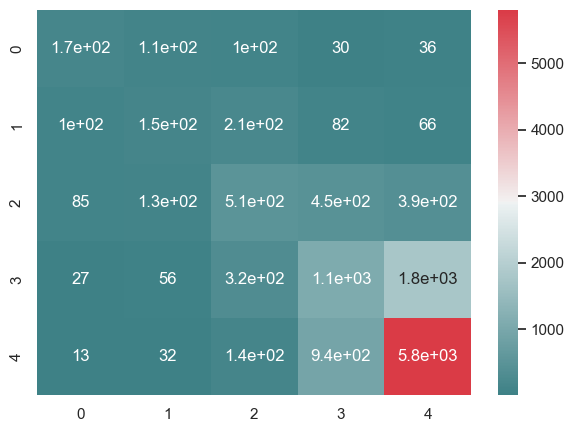

In [30]:
#confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, lr_pred),annot=True,cmap=sns.diverging_palette(200, 10, as_cmap=True,center='light'))
plt.show()

#### Naive Bayes

In [31]:
nb = MultinomialNB()

In [32]:
nb.fit(X_train, y_train)

MultinomialNB()

In [33]:
nb_pred = nb.predict(X_test)

In [34]:
print('accuracy: ', accuracy_score(y_test, nb_pred))
print('precision: ', precision_score(y_test, nb_pred, average='macro'))
print('recall: ', recall_score(y_test, nb_pred, average='macro'))

accuracy:  0.5980307884660467
precision:  0.446295129373343
recall:  0.45037605346906967


In [35]:
print(classification_report(y_test, nb_pred))

              precision    recall  f1-score   support

           1       0.39      0.48      0.43       440
           2       0.30      0.27      0.29       612
           3       0.38      0.33      0.35      1558
           4       0.42      0.36      0.39      3268
           5       0.74      0.81      0.77      6919

    accuracy                           0.60     12797
   macro avg       0.45      0.45      0.45     12797
weighted avg       0.58      0.60      0.59     12797



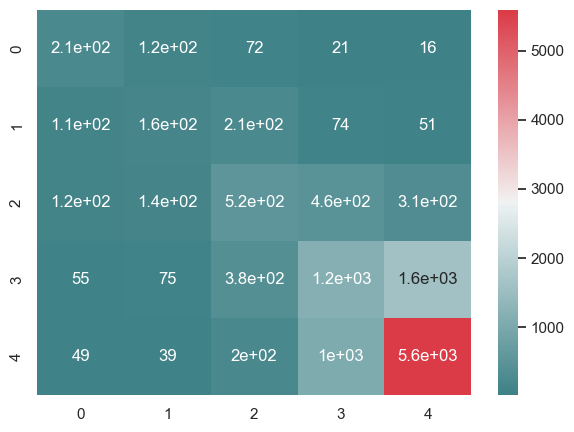

In [36]:
#confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, nb_pred),annot=True,cmap=sns.diverging_palette(200, 10, as_cmap=True,center='light'))
plt.show()

#### SGD classifier

In [37]:
sgd = SGDClassifier()

In [38]:
sgd.fit(X_train, y_train)

SGDClassifier()

In [39]:
sgd_pred = sgd.predict(X_test)

In [40]:
print('accuracy: ', accuracy_score(y_test, sgd_pred))
print('precision: ', precision_score(y_test, sgd_pred, average='macro'))
print('recall: ', recall_score(y_test, sgd_pred, average='macro'))

accuracy:  0.5938110494647183
precision:  0.4197003602398959
recall:  0.4062159004543748


In [41]:
print(classification_report(y_test, sgd_pred))

              precision    recall  f1-score   support

           1       0.35      0.48      0.41       440
           2       0.27      0.14      0.19       612
           3       0.36      0.25      0.30      1558
           4       0.42      0.30      0.35      3268
           5       0.70      0.86      0.77      6919

    accuracy                           0.59     12797
   macro avg       0.42      0.41      0.40     12797
weighted avg       0.56      0.59      0.57     12797



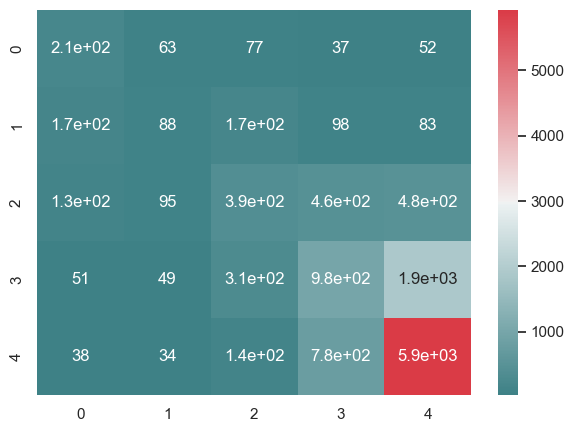

In [42]:
#confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, sgd_pred),annot=True,cmap=sns.diverging_palette(200, 10, as_cmap=True,center='light'))
plt.show()

#### Random forest

In [43]:
rf = RandomForestClassifier()

In [44]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [45]:
rf_pred = rf.predict(X_test)

In [46]:
print('accuracy: ', accuracy_score(y_test, rf_pred))
print('precision: ', precision_score(y_test, rf_pred, average='macro'))
print('recall: ', recall_score(y_test, rf_pred, average='macro'))

accuracy:  0.5602875673986091
precision:  0.5191854028738084
recall:  0.23294243166040288


In [47]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           1       0.77      0.02      0.04       440
           2       0.56      0.01      0.03       612
           3       0.34      0.04      0.08      1558
           4       0.33      0.11      0.17      3268
           5       0.59      0.97      0.73      6919

    accuracy                           0.56     12797
   macro avg       0.52      0.23      0.21     12797
weighted avg       0.50      0.56      0.45     12797



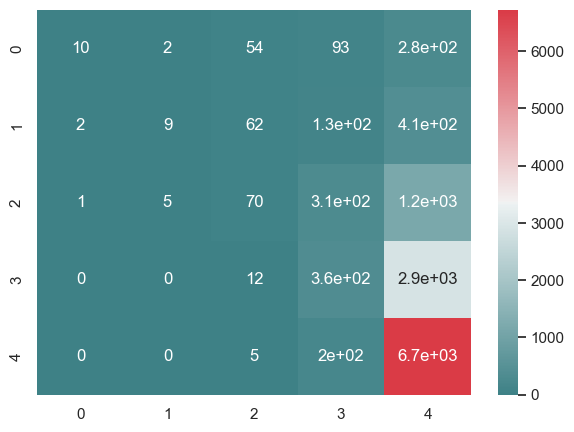

In [48]:
#confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, rf_pred),annot=True,cmap=sns.diverging_palette(200, 10, as_cmap=True,center='light'))
plt.show()

### TF-IDF vectorizer

In [49]:
tfidfvec = TfidfVectorizer(max_features=5000, min_df=5)

In [50]:
stemd = data['stemmed'].apply(lambda tokens: ' '.join(tokens))
tfidfvec_fit = tfidfvec.fit_transform(stemd)

In [51]:
tfidf_bag = pd.DataFrame(tfidfvec_fit.toarray(), columns = tfidfvec.get_feature_names_out())


In [52]:
tfidf_bag


,aaa,abandon,abil,abit,abl,abound,about,abov,abroad,abrupt,...,yuck,yum,yummi,zealand,zero,zip,zocalo,zone,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### modeling 

In [53]:
# split into train and test data
y = raw_data['Rating']
X_train2, X_test2, y_train2, y_test2 = train_test_split(tfidf_bag, y, test_size=0.3, random_state = 42)

#### Logistic Regression

In [54]:
lr2 = LogisticRegression(random_state=0)

In [55]:
lr2.fit(X_train2, y_train2)

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [56]:
lr2_pred = lr2.predict(X_test2)

In [57]:
print('accuracy after TF-IDF: ', accuracy_score(y_test2, lr2_pred))
print('precision after TF-IDF: ', precision_score(y_test2, lr2_pred, average='macro'))
print('recall after TF-IDF: ', recall_score(y_test2, lr2_pred, average='macro'))

accuracy after TF-IDF:  0.615769320934594
precision after TF-IDF:  0.49504996911151233
recall after TF-IDF:  0.40232424644587983


In [58]:
print(classification_report(y_test2, lr2_pred))

              precision    recall  f1-score   support

           1       0.57      0.33      0.42       440
           2       0.35      0.16      0.21       612
           3       0.42      0.32      0.36      1558
           4       0.43      0.34      0.38      3268
           5       0.71      0.87      0.78      6919

    accuracy                           0.62     12797
   macro avg       0.50      0.40      0.43     12797
weighted avg       0.58      0.62      0.59     12797



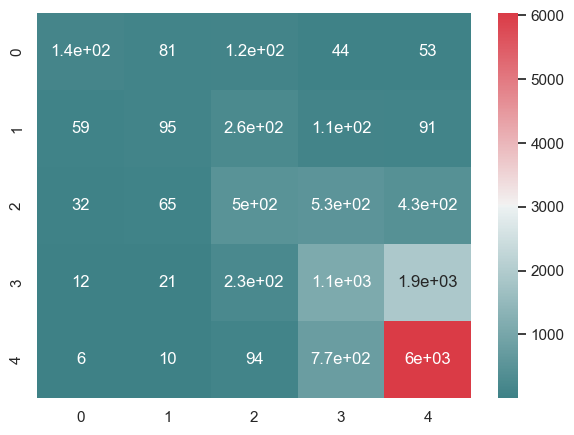

In [59]:
#confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test2, lr2_pred),annot=True,cmap=sns.diverging_palette(200, 10, as_cmap=True,center='light'))
plt.show()

#### we can observe that this is better with TF-IDF than with bag of words

#### Naive Bayes

In [60]:
nb2 = MultinomialNB()

In [61]:
nb2.fit(X_train2, y_train2)

MultinomialNB()

In [62]:
nb2_pred = nb2.predict(X_test2)

In [63]:
print('accuracy after TF-IDF: ', accuracy_score(y_test2, nb2_pred))
print('precision after TF-IDF: ', precision_score(y_test2, nb2_pred, average='macro'))
print('recall after TF-IDF: ', recall_score(y_test2, nb2_pred, average='macro'))

accuracy after TF-IDF:  0.5677111823083535
precision after TF-IDF:  0.4331629940398495
recall after TF-IDF:  0.24110063799060527


In [64]:
print(classification_report(y_test2, nb2_pred))

              precision    recall  f1-score   support

           1       0.64      0.02      0.04       440
           2       0.27      0.00      0.01       612
           3       0.32      0.09      0.14      1558
           4       0.33      0.12      0.18      3268
           5       0.60      0.97      0.74      6919

    accuracy                           0.57     12797
   macro avg       0.43      0.24      0.22     12797
weighted avg       0.48      0.57      0.47     12797



## N-grams

#### _bigrams: n=2_

In [65]:
data['bigrams'] = data['stemmed'].apply(lambda tokens: [' '.join(gram) for gram in ngrams(tokens, 2)])
data.head()

,Review_Text,lowercase,no_stopwords,no_punct,tokenized,stemmed,bigrams
0,If you've ever been to Disneyland anywhere you...,if you've ever been to disneyland anywhere you...,ever disneyland anywhere find disneyland hong ...,ever disneyland anywhere find disneyland hong ...,"[ever, disneyland, anywhere, find, disneyland,...","[ever, disneyland, anywher, find, disneyland, ...","[ever disneyland, disneyland anywher, anywher ..."
1,Its been a while since d last time we visit HK...,its been a while since d last time we visit hk...,"since last time visit hk disneyland .. yet, ti...",since last time visit hk disneyland yet time ...,"[since, last, time, visit, hk, disneyland, yet...","[sinc, last, time, visit, hk, disneyland, yet,...","[sinc last, last time, time visit, visit hk, h..."
2,Thanks God it wasn t too hot or too humid wh...,thanks god it wasn t too hot or too humid wh...,thanks god hot humid visiting park otherwise w...,thanks god hot humid visiting park otherwise w...,"[thanks, god, hot, humid, visiting, park, othe...","[thank, god, hot, humid, visit, park, otherwis...","[thank god, god hot, hot humid, humid visit, v..."
3,HK Disneyland is a great compact park. Unfortu...,hk disneyland is a great compact park. unfortu...,hk disneyland great compact park. unfortunatel...,hk disneyland great compact park unfortunately...,"[hk, disneyland, great, compact, park, unfortu...","[hk, disneyland, great, compact, park, unfortu...","[hk disneyland, disneyland great, great compac..."
4,"the location is not in the city, took around 1...","the location is not in the city, took around 1...","location not city, took around 1 hour kowlon, ...",location not city took around hour kowlon kid...,"[location, not, city, took, around, hour, kowl...","[locat, not, citi, took, around, hour, kowlon,...","[locat not, not citi, citi took, took around, ..."


In [66]:
text = data['bigrams'].apply(lambda bigrams: ' '.join(bigrams))

tfidf = TfidfVectorizer(max_features=5000, min_df=5)
tfidf_matrix = tfidf.fit_transform(text)


In [68]:
tfidf_bag2 = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_bag2

,aaa,abandon,abil,abit,abl,abound,about,abov,abroad,abrupt,...,yuck,yum,yummi,zealand,zero,zip,zocalo,zone,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### modeling

In [69]:
# split into train and test data
y = raw_data['Rating']
X_train3, X_test3, y_train3, y_test3 = train_test_split(tfidf_bag2, y, test_size=0.3, random_state = 42)

##### Logistic Regression

In [70]:
lr3 = LogisticRegression(random_state=0)

In [71]:
lr3.fit(X_train3, y_train3)

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [73]:
lr3_pred = lr3.predict(X_test3)

In [74]:
print('accuracy after bigram & TF-IDF: ', accuracy_score(y_test3, lr3_pred))
print('precision after bigram & TF-IDF ', precision_score(y_test3, lr3_pred, average='macro'))
print('recall after bigram & TF-IDF ', recall_score(y_test3, lr3_pred, average='macro'))

accuracy after bigram & TF-IDF:  0.6138157380636087
precision after bigram & TF-IDF  0.49252123420937927
recall after bigram & TF-IDF  0.39900402320602374


In [75]:
print(classification_report(y_test3, lr3_pred))

              precision    recall  f1-score   support

           1       0.55      0.32      0.40       440
           2       0.37      0.16      0.22       612
           3       0.40      0.31      0.35      1558
           4       0.43      0.34      0.38      3268
           5       0.71      0.87      0.78      6919

    accuracy                           0.61     12797
   macro avg       0.49      0.40      0.43     12797
weighted avg       0.58      0.61      0.59     12797



In [76]:
raw_data.Rating.value_counts()

5    23146
4    10775
3     5109
2     2127
1     1499
Name: Rating, dtype: int64

<Axes: >

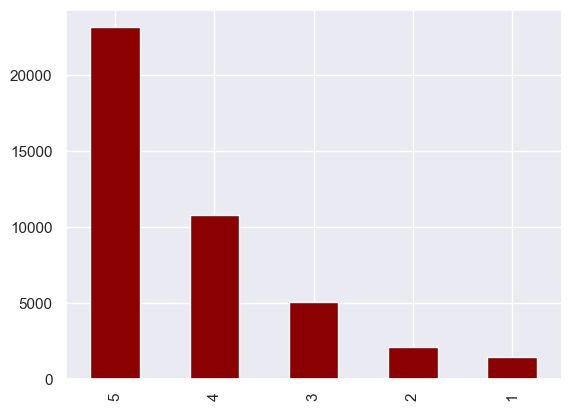

In [77]:
raw_data.Rating.value_counts().plot.bar(color='darkred')

##### Observation:
*we notice data imbalance*